<a href="https://colab.research.google.com/github/danjcyr/BassAlignmentStudy/blob/main/BassAlignmentStudy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#first some imports

import matplotlib.pyplot as plt
import scipy
import cmath
from scipy import signal
import math
import numpy as np
from scipy.signal.windows import blackmanharris, tukey, kaiser
from scipy.signal import lti, lsim, bode, freqz, butter, bessel, hilbert, TransferFunction


In [2]:
# @title
# need these for Bessel 4th order responses
bessel_coeffs = {'4':{'Q':{0.80554,0.521936},'Fx':{1.05882,0.94445}}}

In [3]:
# @title
def first_order_high_pass(f0):
    """
    Creates a first-order high-pass filter transfer function.

    Parameters:
    f0 (float): The corner frequency in Hz.

    Returns:
    scipy.signal.lti: The transfer function of the filter.
    """
    w0 = f0 * 2 * math.pi
    return lti([1, 0], [1, w0])

def second_order_low_pass(f0, Q):
    """
    Creates a second-order low-pass filter transfer function.

    Parameters:
    f0 (float): The corner frequency in Hz.
    Q (float): The quality factor of the filter.

    Returns:
    scipy.signal.lti: The transfer function of the filter.
    """
    w0 = f0 * 2 * math.pi
    return lti([w0**2], [1, w0/Q, w0**2])

def second_order_high_pass(f0, Q):
    """
    Creates a second-order high-pass filter transfer function.

    Parameters:
    f0 (float): The corner frequency in Hz.
    Q (float): The quality factor of the filter.

    Returns:
    scipy.signal.lti: The transfer function of the filter.
    """
    w0 = f0 * 2 * math.pi
    return lti([1, 0, 0], [1, w0/Q, w0**2])

def create_butterworth_filter(order, corner_frequency, btype='low'):
    """
    Create a Butterworth filter of specified order and corner frequency.

    Parameters:
    order (int): The order of the filter.
    corner_frequency (float): The corner frequency of the filter in Hz.
    btype (str): Type of the filter, 'low' for lowpass or 'high' for highpass.

    Returns:
    scipy.signal.lti: The transfer function of the filter.
    """
    b, a = butter(order, corner_frequency * 2 * math.pi, btype=btype, analog=True)
    return lti(b, a)

def create_bessel_filter(order, corner_frequency, btype='low'):
    """
    Create a Bessel filter of specified order and corner frequency.

    Parameters:
    order (int): The order of the filter.
    corner_frequency (float): The corner frequency of the filter in Hz.
    btype (str): Type of the filter, 'low' for lowpass or 'high' for highpass.

    Returns:
    scipy.signal.lti: The transfer function of the filter.
    """
    b, a = bessel(order, corner_frequency * 2 * math.pi, btype=btype, analog=True)
    return lti(b, a)

def create_linkwitz_riley(order, corner_frequency, btype='low'):
    """
    Create a Linkwitz-Riley filter of specified order and corner frequency.

    Parameters:
    order (int): The order of the filter. Must be even.
    corner_frequency (float): The corner frequency of the filter in Hz.
    btype (str): Type of the filter, 'low' for lowpass or 'high' for highpass.

    Returns:
    scipy.signal.lti: The transfer function of the filter.
    """
    if order % 2 != 0:
        raise ValueError("Order must be even for Linkwitz-Riley filters.")
    half_order = order // 2
    b1, a1 = butter(half_order, corner_frequency * 2 * math.pi, btype=btype, analog=True)
    b2, a2 = butter(half_order, corner_frequency * 2 * math.pi, btype=btype, analog=True)
    b_lr, a_lr = np.polymul(b1, b2), np.polymul(a1, a2)
    return lti(b_lr, a_lr)

def plot_frequency_response_dB(lti_systems, labels, low_freq=10, high_freq=20000, title='Frequency Response in dB'):
    """
    Plots the frequency response of multiple LTI systems in decibels.

    Parameters:
    lti_systems (list of scipy.signal.lti): List of LTI system objects.
    labels (list of str): Labels for the LTI systems.
    low_freq (float): Low frequency limit of the plot in Hz.
    high_freq (float): High frequency limit of the plot in Hz.
    title (str): Title of the plot.
    """
    frequencies = np.logspace(np.log10(2 * math.pi * low_freq), np.log10(2 * math.pi * high_freq), 10000)
    plt.figure(figsize=(11, 3))
    for lti, label in zip(lti_systems, labels):
        w, mag, phase = lti.bode(w=frequencies)
        plt.semilogx(w/(2 * math.pi), mag, label=label)
    plt.ylim(-50, 5)
    plt.title(title)
    plt.xlabel('Frequency [Hz]')
    plt.ylabel('Magnitude [dB]')
    plt.legend()
    plt.grid(which='both', linestyle='-', linewidth='0.5')
    plt.show()
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import freqresp, bode

def calc_analog_group_delay(lti_system, freq_range):
    """
    Calculates the group delay of an analog LTI system over a specified frequency range.

    Parameters:
    lti_system (scipy.signal.lti): The analog LTI system.
    freq_range (tuple): A tuple (start, stop) specifying the frequency range in Hz.

    Returns:
    numpy.ndarray: Midpoint frequencies for the group delay plot.
    numpy.ndarray: Group delay values in milliseconds.
    """
    # Define the frequency range
    freqs = np.logspace(np.log10(freq_range[0]), np.log10(freq_range[1]), 10000)

    # Compute the frequency response
    w, h = freqresp(lti_system, w=freqs * 2 * np.pi)

    # Extract and unwrap the phase response
    phase = np.unwrap(np.angle(h))

    # Numerically differentiate the phase to compute the group delay
    group_delay = -np.diff(phase) / np.diff(w)
    mid_freqs = (freqs[:-1] + freqs[1:]) / 2  # Midpoint of frequency intervals

    # Convert group delay to milliseconds
    group_delay_ms = group_delay * 1000

    return mid_freqs, group_delay_ms

def plot_group_delay(lti_systems, labels, low_freq=20, high_freq=20000, title='Group Delay in ms'):
    """
    Plots the group delay of multiple LTI systems.

    Parameters:
    lti_systems (list of scipy.signal.lti): List of LTI systems.
    labels (list of str): Labels for the LTI systems.
    low_freq (float): Lower bound of the frequency range in Hz.
    high_freq (float): Upper bound of the frequency range in Hz.
    title (str): Title of the plot.
    """
    plt.figure(figsize=(11, 3))

    for lti_system, label in zip(lti_systems, labels):
        mid_freqs, group_delay = calc_analog_group_delay(lti_system, (low_freq, high_freq))
        plt.semilogx(mid_freqs, group_delay, label=label)

    plt.title(title)
    plt.xlabel('Frequency [Hz]')
    plt.ylabel('Group Delay [ms]')
    plt.legend()
    plt.grid(which='both', linestyle='-', linewidth='0.5')
    plt.show()

def cascade_lti(lti1, lti2):
    return signal.lti(np.polymul(lti1.num,lti2.num),np.polymul(lti1.den,lti2.den))


In [4]:
def add_lti_systems(lti1, lti2, scale = (1,1)):
    """
    Adds two LTI systems and returns the combined system.

    Parameters:
    lti1 (scipy.signal.lti): The first LTI system.
    lti2 (scipy.signal.lti): The second LTI system.

    Returns:
    scipy.signal.lti: The combined LTI system.
    """

    num1, den1 = np.polymul(scale[0]*lti1.num, lti2.den), np.polymul(lti1.den, lti2.den)
    num2, den2 = np.polymul(scale[1]*lti2.num, lti1.den), np.polymul(lti2.den, lti1.den)

    sum_num = np.polyadd(num1, num2)
    sum_den = den1  # Since den1 == den2

    # Create the resulting transfer function
    tf_parallel = TransferFunction(sum_num, sum_den)

    # Convert to LTI system if needed
    lti_parallel = lti(sum_num, sum_den)


    # Create the combined LTI system
    return lti_parallel


In [16]:
hp1 = create_butterworth_filter(4,40,'high')
hp2 = create_bessel_filter(2,20,'high')
hp3 = signal.lti([1],[1])
lp1 = create_linkwitz_riley(4,400)
woofer = cascade_lti(hp2,lp1)
label_woofer = "bess2_40_lr2_300"
hp4 = create_linkwitz_riley(4,400,btype='high')
lp2 = create_linkwitz_riley(2,23000)
mid = cascade_lti(hp4,lp2)
combined = add_lti_systems(woofer,mid,scale=(1,1))
label_combined = 'combined'
label_mid = "mid - LR4 300, 3000"
hp1_label = "B4 40hz"
hp2_label = "Bessl2 40hz"
hp3_label = "Input Signal"
lti_systems=[woofer,mid,combined]
labels_systems=[label_woofer,label_mid,label_combined]

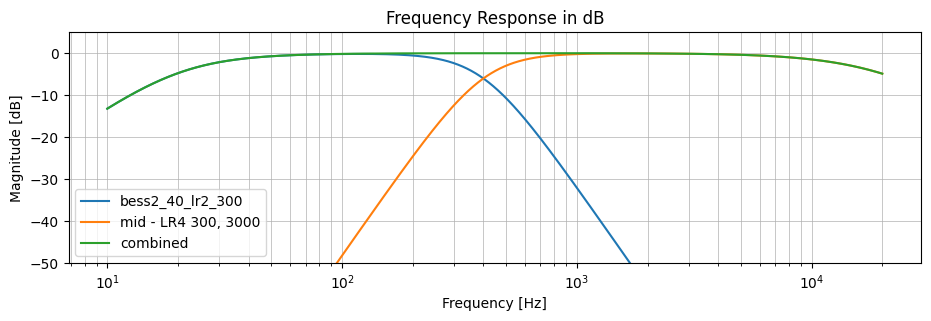

In [17]:
plot_frequency_response_dB(lti_systems,labels_systems)

In [18]:

def plot_step_impulse_response(lti_systems, labels, step=True, t0=0, t1=0.5, title='Response', t_lead=0.02):
    """
    Plots the step or impulse response of multiple LTI systems.

    Parameters:
    lti_systems (list of scipy.signal.lti): List of LTI system objects.
    labels (list of str): Labels for the LTI systems.
    step (bool): If True, plot the step response; otherwise, plot the impulse response.
    t0 (float): Start time for the response plot in milliseconds.
    t1 (float): End time for the response plot in milliseconds.
    title (str): Title of the plot.
    t_lead (float): Lead time for the response plot in milliseconds.
    """
    # Create a time array
    t = np.linspace(t0, t1, 5000)
    t_lead_array = np.linspace(-t_lead, 0, 100)
    response_lead = np.zeros(t_lead_array.shape)

    plt.figure(figsize=(11, 3))

    for lti_system, label in zip(lti_systems, labels):
        # Compute response
        if step:
            time, response = lti_system.step(T=t)
        else:
            time, response = lti_system.impulse(T=t)

        # Concatenate lead time and response time
        time_combined = np.concatenate((t_lead_array, time))
        response_combined = np.concatenate((response_lead, response))

        # Plot response
        plt.plot(time_combined * 1000, response_combined, label=label)

    # Update title based on response type
    title = ("Step " if step else "Impulse ") + title

    plt.title(title)
    plt.xlabel('Time [ms]')
    plt.ylabel('Response')
    plt.legend()
    plt.grid(True)
    plt.show()






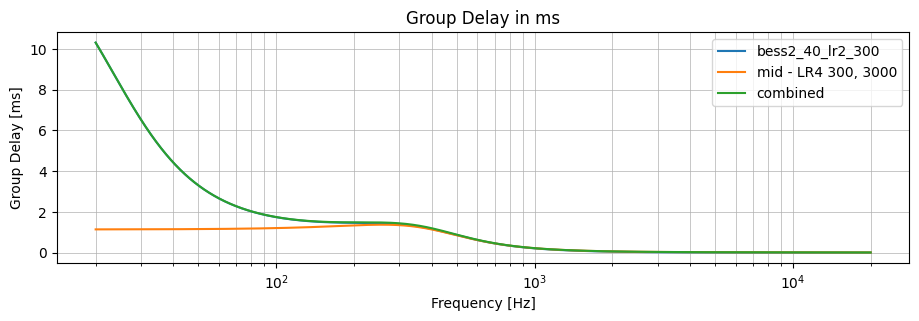

In [19]:
plot_group_delay(lti_systems,labels_systems)

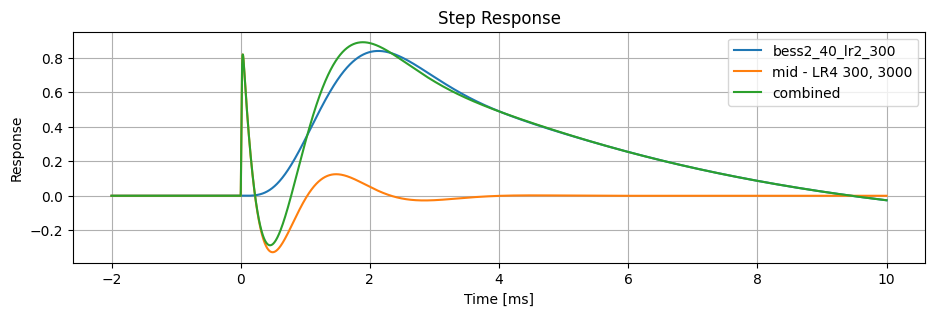

In [23]:
plot_step_impulse_response(lti_systems,labels_systems,t1=0.01,t_lead=0.002)

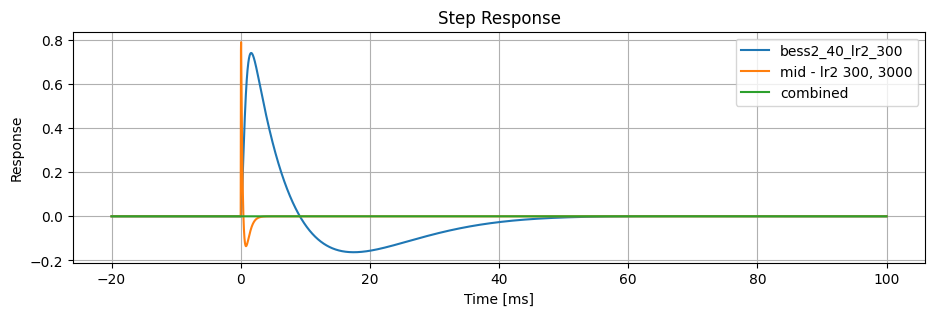

In [55]:
plot_step_impulse_response(lti_systems,labels_systems,t1=0.1)

In [56]:

def generate_toneburst_with_window(frequency=30, cycles_in_burst=4, periods_between_bursts=1, lead_periods=5, sample_rate=96000, single=False):
    """
    Generates a toneburst signal with a Blackman-Harris window applied to the bursts.

    Parameters:
    frequency (float): The frequency of the toneburst in Hz. Default is 30 Hz.
    cycles_in_burst (int): The number of cycles in each burst. Default is 4.
    periods_between_bursts (int): The number of cycles between bursts as a period of silence. Default is 5.
    lead_periods (int): The number of lead-in cycles before the first burst. Default is 5.
    sample_rate (int): The sample rate of the signal in samples per second. Default is 96000.

    Returns:
    numpy.ndarray: The time array corresponding to the toneburst signal.
    numpy.ndarray: The generated toneburst signal.
    """
    # Calculate times for burst, silence, and lead segments
    cycle_time = 1.0 / frequency
    burst_time = cycles_in_burst * cycle_time
    silence_time = periods_between_bursts * cycle_time
    lead_time = lead_periods * cycle_time

    # Calculate the number of samples for each segment
    num_samples_burst = int(burst_time * sample_rate)
    num_samples_silence = int(silence_time * sample_rate)
    num_samples_lead = int(lead_time * sample_rate)

    # Generate the burst segment with a window function
    burst_segment = np.sin(2 * np.pi * frequency * np.linspace(0, burst_time, num_samples_burst, endpoint=False))
    window = blackmanharris(num_samples_burst)
    burst_segment *= window

    # Generate silence and lead segments
    silence_segment = np.zeros(num_samples_silence)
    lead_segment = np.zeros(num_samples_lead)
    lead_segment2 = np.zeros(num_samples_lead * 5)

    # Concatenate the segments to form the toneburst signal
    if single:
      toneburst_signal = np.concatenate((lead_segment, burst_segment, lead_segment2))
    else:
      toneburst_signal = np.concatenate((lead_segment, burst_segment, silence_segment, burst_segment, lead_segment2))


    # Create the time array for the signal
    T = np.linspace(0, len(toneburst_signal) / sample_rate, len(toneburst_signal), endpoint=False)

    return T, toneburst_signal


def plot_lti_response_to_toneburst(lti_systems, labels, frequency=30, cycles_in_burst=4, periods_between_bursts=3, lead_periods=1, sample_rate=96000, show_envelope=True, show_response=True,single=False):
    """
    Plots the response of multiple LTI systems to a generated toneburst signal.

    Parameters:
    lti_systems (list of scipy.signal.lti): List of LTI system objects.
    labels (list of str): Labels for the LTI systems for the plot legend.
    frequency (float): Frequency of the toneburst in Hz. Default is 30 Hz.
    cycles_in_burst (int): Number of cycles in each toneburst. Default is 4.
    periods_between_bursts (int): Number of silent periods between bursts. Default is 3.
    lead_periods (int): Number of lead-in periods before and after the bursts. Default is 1.
    sample_rate (int): Sampling rate in Hz. Default is 96000.

    Note: This function depends on the 'generate_toneburst_with_window' function.
    """
    # Generate the toneburst signal
    T, U = generate_toneburst_with_window(frequency, cycles_in_burst, periods_between_bursts, lead_periods * 0.5, sample_rate,single)

    # Set up the plot
    plt.figure(figsize=(11, 4))

    # Plot the response of each LTI system
    for lti_system, label in zip(lti_systems, labels):
        _, response, _ = lsim(lti_system, U, T)
        envelope = np.abs(hilbert(response))
        if show_response:
          plt.plot(T * 1000, response, label=label)
        if show_envelope:
          plt.plot(T * 1000, envelope, label="Envelope " + label)

    # Configure plot settings
    plt.title(f'System Response to {frequency} Hz Toneburst Signal')
    plt.xlabel('Time (ms)')
    plt.ylabel('Response')
    plt.legend()
    plt.grid()
    plt.show()


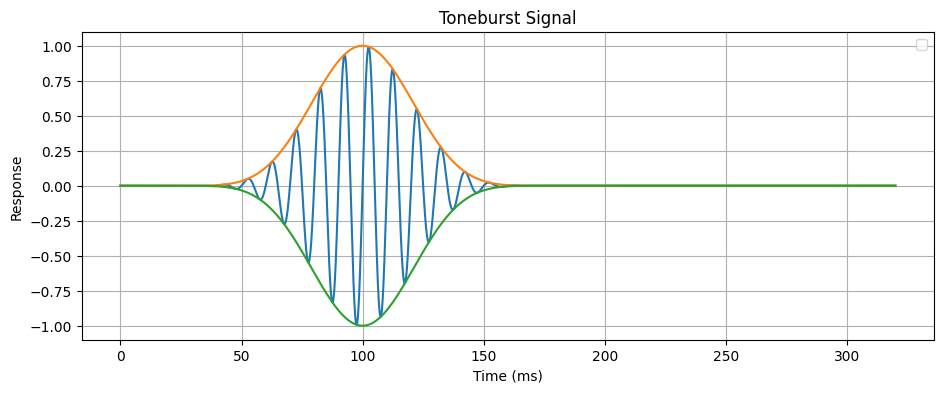

In [57]:
times, toneburst = generate_toneburst_with_window(frequency=100, cycles_in_burst=14, periods_between_bursts=0, lead_periods=3, sample_rate=96000,single=True)
plt.figure(figsize=(11, 4))
plt.plot(times * 1000, toneburst)
plt.plot(times * 1000, np.abs(hilbert(toneburst)))
plt.plot(times * 1000, -np.abs(hilbert(toneburst)))
plt.title(f'Toneburst Signal')
plt.xlabel('Time (ms)')
plt.ylabel('Response')
plt.legend()
plt.grid()
plt.show()

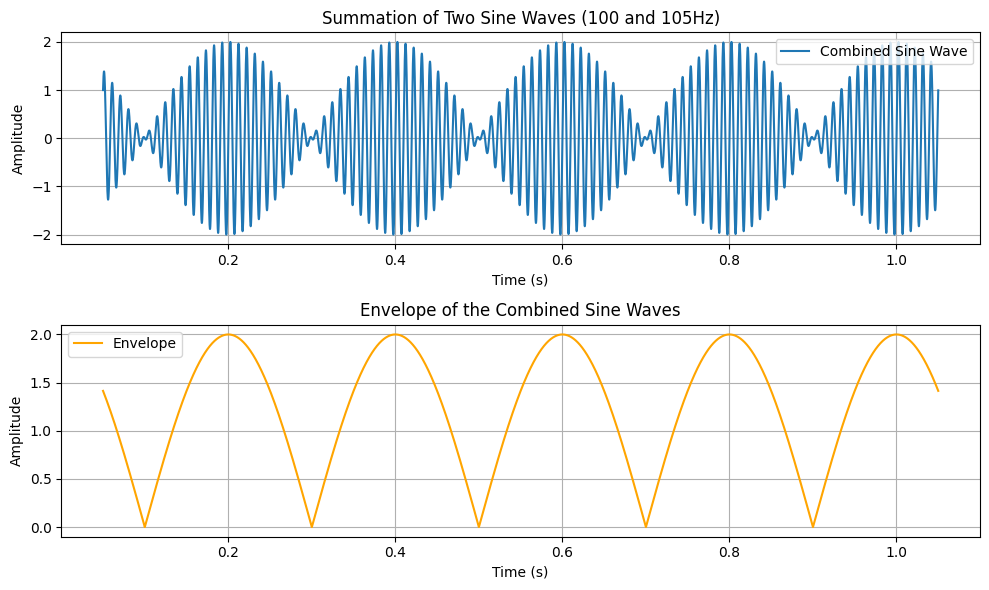

In [58]:
def plot_sine_waves_and_envelope(freq1, freq2, duration, sample_rate):
    """
    Plots the summation of two sine waves of slightly different frequency and the envelope of the result.

    :param freq1: Frequency of the first sine wave.
    :param freq2: Frequency of the second sine wave.
    :param duration: Duration of the signal in seconds.
    :param sample_rate: Sampling rate in Hz.
    """
    # Time array
    t = np.linspace(0+0.05, duration+0.05, int(sample_rate * duration), endpoint=False)

    # Create two sine waves
    sine_wave1 = np.sin(2 * np.pi * freq1 * t)
    sine_wave2 = np.sin(2 * np.pi * freq2 * t)

    # Summation of the two sine waves
    combined_sine = sine_wave1 + sine_wave2

    # Calculate the envelope using the Hilbert transform
    envelope = np.abs(hilbert(combined_sine))

    # Plotting
    plt.figure(figsize=(10, 6))

    # Plotting the combined sine wave
    plt.subplot(2, 1, 1)
    plt.plot(t, combined_sine, label='Combined Sine Wave')
    plt.title('Summation of Two Sine Waves (100 and 105Hz)')
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.grid(True)
    plt.legend()

    # Plotting the envelope
    plt.subplot(2, 1, 2)
    plt.plot(t, envelope, label='Envelope', color='orange')
    plt.title('Envelope of the Combined Sine Waves')
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.grid(True)
    plt.legend()

    plt.tight_layout()
    plt.show()

# Example usage
plot_sine_waves_and_envelope(freq1=100, freq2=105, duration=1, sample_rate=96000)


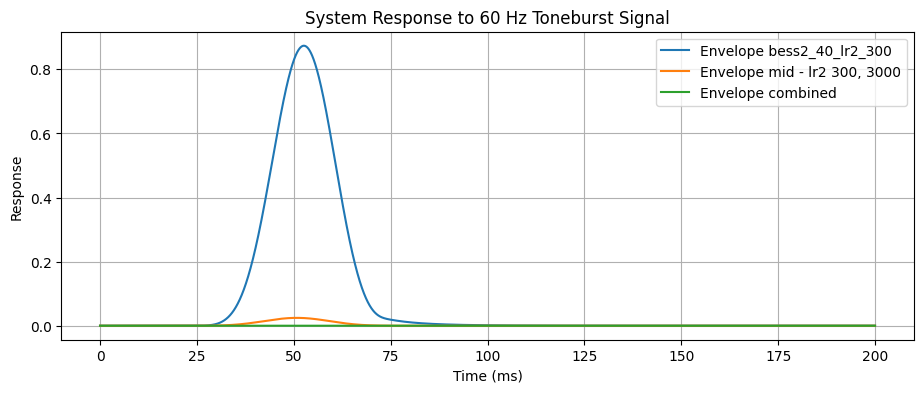

In [59]:
plot_lti_response_to_toneburst(lti_systems, labels_systems, frequency=60,
                               cycles_in_burst=3, periods_between_bursts=0,
                               lead_periods=3, sample_rate=96000,show_response=False,single=True)

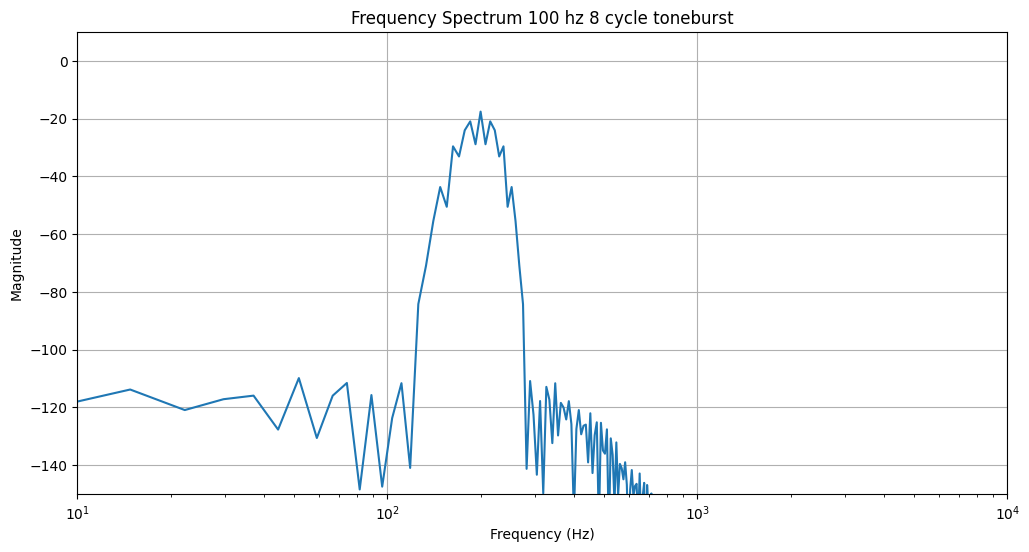

In [60]:
def plot_frequency_spectrum(signal, sample_rate):
    """Plots the frequency spectrum of a given signal on a semi-logarithmic x-axis."""
    # Compute the FFT (Fast Fourier Transform) of the signal
    fft_spectrum = np.fft.fft(signal)
    fft_freq = np.fft.fftfreq(len(signal), 1 / sample_rate)

    # Take the magnitude of the FFT and normalize
    magnitude = np.abs(fft_spectrum) / len(signal)

    # Plotting
    plt.figure(figsize=(12, 6))
    plt.semilogx(fft_freq, 20*np.log10(magnitude))  # Using semilogx for logarithmic x-axis
    plt.title("Frequency Spectrum 100 hz 8 cycle toneburst")
    plt.xlabel("Frequency (Hz)")
    plt.ylabel("Magnitude")
    plt.grid(True)
    plt.xlim(10, 10000)  # Limit x-axis to positive frequencies only
    plt.ylim(-150,10)
    plt.show()

# Generate the toneburst signal
T, U = generate_toneburst_with_window(frequency=200, cycles_in_burst=10, periods_between_bursts=1, lead_periods=1, sample_rate=96000,single=False)

# Plot the frequency spectrum on a semi-logarithmic x-axis
plot_frequency_spectrum(U, 96000)


In [61]:
import soundfile as sf

def save_as_wav(array, sample_rate, file_name):
    """
    Saves a NumPy array as a 32-bit float mono WAV file.

    Parameters:
    array (numpy.ndarray): The audio data to save.
    sample_rate (int): The sample rate of the audio data.
    file_name (str): The name of the file to save.
    """
    # Ensure the file name ends with .wav
    if not file_name.endswith('.wav'):
        file_name += '.wav'

    # Write the file
    sf.write(file_name, array, sample_rate, subtype='FLOAT')


In [62]:
save_as_wav(U,96000,"200hztb.wav")

In [63]:
from scipy.signal import TransferFunction, lti
import numpy as np

# Define your two continuous transfer functions
# For example, tf1 = TransferFunction([numerator coefficients], [denominator coefficients])
tf1 = TransferFunction([1], [1, 2, 1])  # Example tf1(s) = 1 / (s^2 + 2s + 1)
tf2 = TransferFunction([2], [1, 3, 3, 1])  # Example tf2(s) = 2 / (s^3 + 3s^2 + 3s + 1)

tf1=woofer
tf2=mid
# Add the transfer functions in parallel
# Find a common denominator (lcd) for the addition
num1, den1 = np.polymul(tf1.num, tf2.den), np.polymul(tf1.den, tf2.den)
num2, den2 = np.polymul(-tf2.num, tf1.den), np.polymul(tf2.den, tf1.den)
sum_num = np.polyadd(num1, num2)
sum_den = den1  # Since den1 == den2

# Create the resulting transfer function
tf_parallel = TransferFunction(sum_num, sum_den)

# Convert to LTI system if needed
lti_parallel = lti(sum_num, sum_den)

# Now tf_parallel or lti_parallel represents the parallel combination of tf1 and tf2


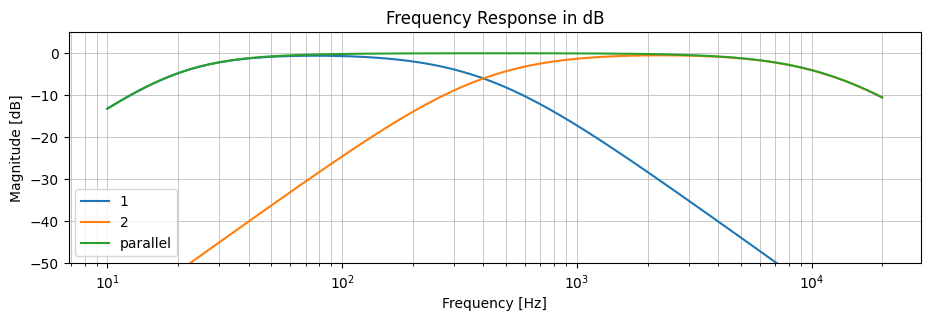

In [64]:
plot_frequency_response_dB([tf1, tf2,lti_parallel],["1","2","parallel"])

In [39]:
print(tf_parallel)

TransferFunctionContinuous(
array([6.67816912e+09, 3.60521964e+13, 9.69176277e+16, 2.28054419e+20,
       2.66864166e+23, 0.00000000e+00, 0.00000000e+00]),
array([1.00000000e+00, 1.73633570e+05, 8.38981482e+09, 7.51482244e+13,
       2.79364072e+17, 4.88646967e+20, 3.63988694e+23, 6.47329472e+25,
       4.20364089e+27]),
dt: None
)


In [40]:
print(lti_parallel)

TransferFunctionContinuous(
array([6.67816912e+09, 3.60521964e+13, 9.69176277e+16, 2.28054419e+20,
       2.66864166e+23, 0.00000000e+00, 0.00000000e+00]),
array([1.00000000e+00, 1.73633570e+05, 8.38981482e+09, 7.51482244e+13,
       2.79364072e+17, 4.88646967e+20, 3.63988694e+23, 6.47329472e+25,
       4.20364089e+27]),
dt: None
)
